# Supervised Learning - Project

In this Project, we are going to perform a full supervised learning machine learning project on a "Diabetes" dataset. This dataset is originally from the National Institute of Diabetes and Digestive and Kidney
Diseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes,
based on certain diagnostic measurements included in the dataset. 

[Kaggle Dataset](https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


# Part I : EDA - Exploratory Data Analysis

For this task, you are required to conduct an exploratory data analysis on the diabetes dataset. You have the freedom to choose the visualizations you want to use, but your analysis should cover the following tasks mostly:

- Are there any missing values in the dataset?
- How are the predictor variables related to the outcome variable?
- What is the correlation between the predictor variables?
- What is the distribution of each predictor variable?
- Are there any outliers in the predictor variables?
- How are the predictor variables related to each other?
- Is there any interaction effect between the predictor variables?
- What is the average age of the individuals in the dataset?
- What is the average glucose level for individuals with diabetes and without diabetes?
- What is the average BMI for individuals with diabetes and without diabetes?
- How does the distribution of the predictor variables differ for individuals with diabetes and without diabetes?
- Are there any differences in the predictor variables between males and females (if gender information is available)?

### **`Importing dataset`**



In [3]:
# Importing dataset
df = pd.read_csv('diabetes.csv')

# lets look at the first set of rows..
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### **`Checking for missing values`**

In [4]:
missing_values = df.isnull().sum()

missing_values

# we can see no missing values which great.

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### **`Relationship between predictors and outcome`**

Out of all predictors we can see that 'Glucose' has the highest (positive) correlation with our outcome variable and 'blood pressure' has the lowest. 

It's important to note that correlation is not causation however, when model-building later on, weaker correlated predictors may be worth dropping to improve performance. Let's see further down.

In [5]:
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['Outcome'].abs().sort_values(ascending=False)

correlation_with_target

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64

Checking correlations between all variables:

we can see strong/relatively strong relationships between:

* pregnancies and age - .54
* glucose and the outcome variable - 0.47
* skin thickness and insulin levels - 0.44
* skin thickness and BMI - 0.39
* glucose and insulin levels - 0.33

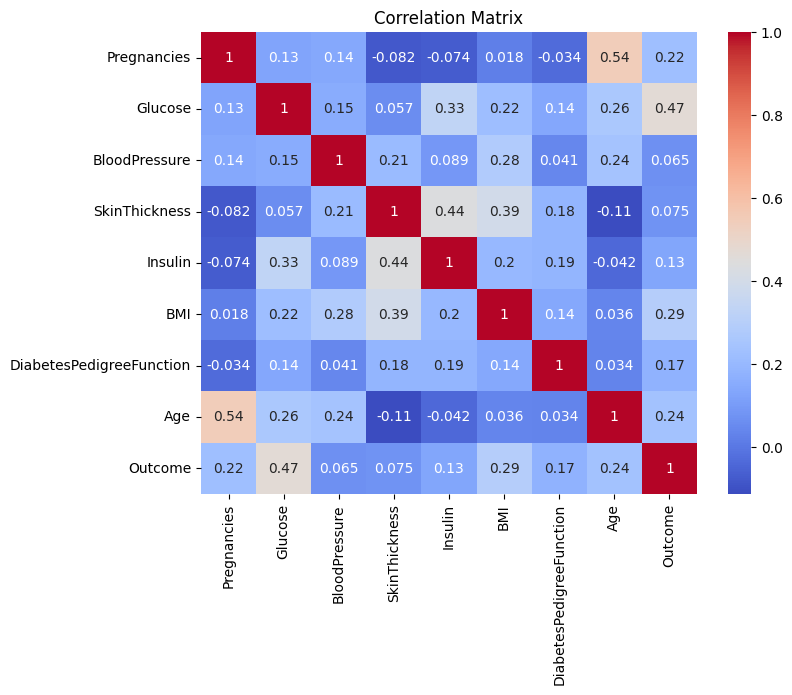

In [6]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

plt.show()

### **`Distribution of All Predictor Variables`**

There appear to be outliers in:

* Glucose - there is a small count of glucose levels between 0 and 25
* Blood Pressure - there appears to be count of ~40 of blood pressures outside the main distribution
* Skin Thickness - a small count of values ~100
* BMI - a small count of values outside the main distribution (~0)

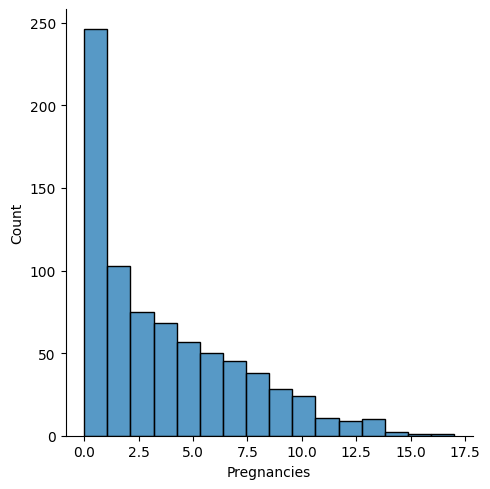

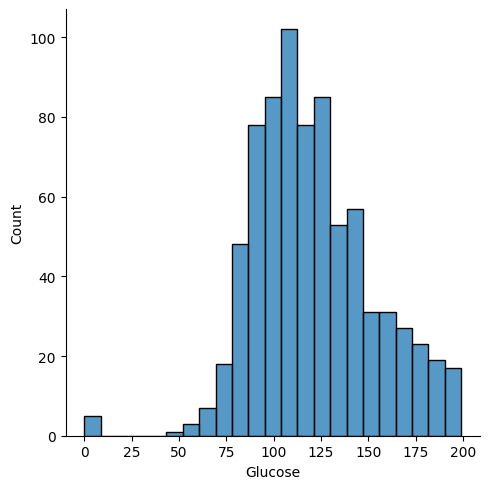

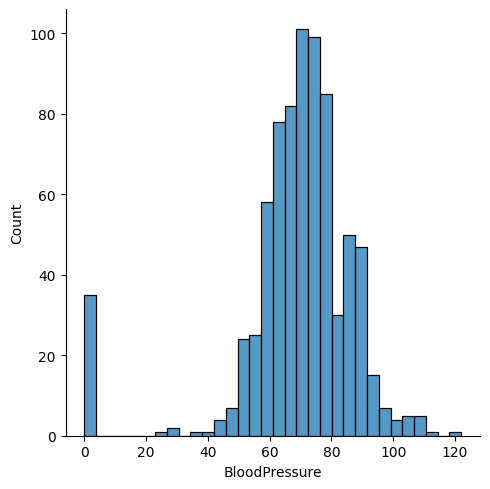

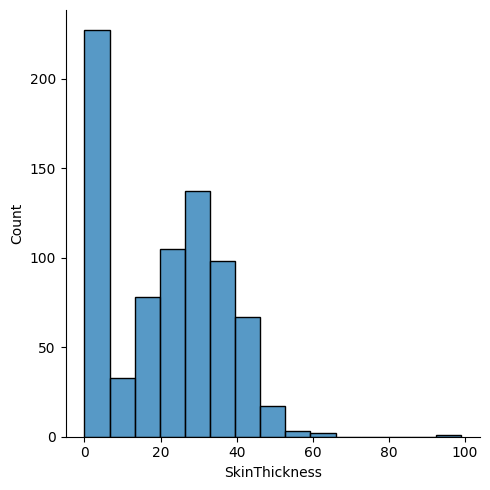

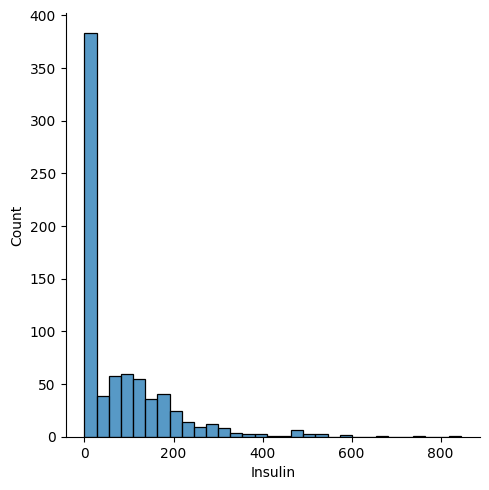

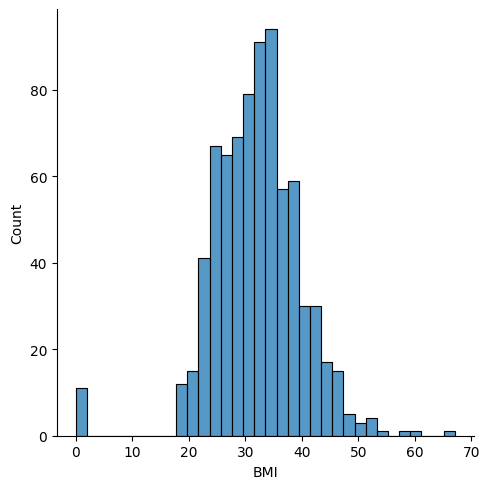

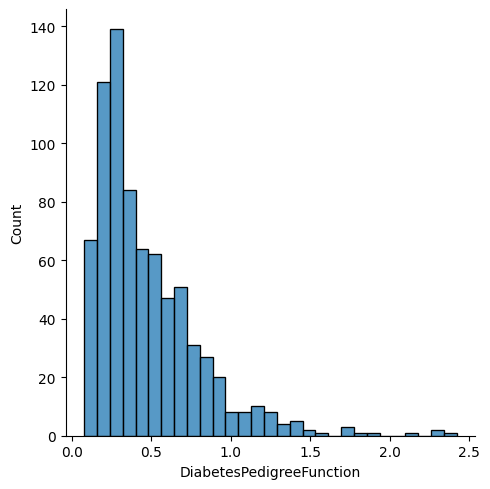

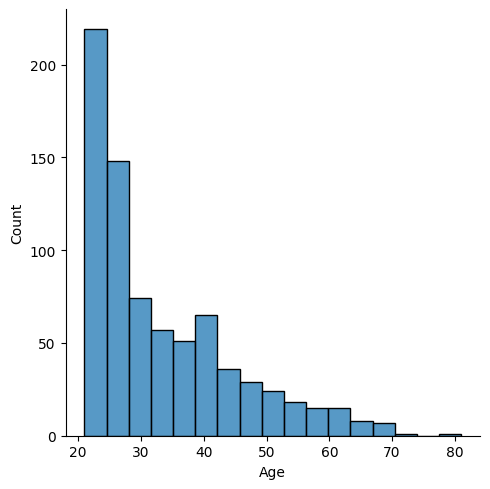

In [7]:
predictors = df.drop(columns=['Outcome'])

for predictor in predictors:
    sns.displot(df[predictor])

### **`Average Age`**

In [8]:
average_age = df['Age'].mean()

print(f'The average age in the dataset is: {average_age:.2f}')

The average age in the dataset is: 33.24


While that's interesting, lets see what the average age is of those WITH diabetes

In [9]:
avg_age_diabetes = df[df['Outcome'] == 1]['Age'].mean()

avg_age_no_diabetes = df[df['Outcome'] == 0]['Age'].mean()

print(f'The average age of those WITH diabetes is: {avg_age_diabetes:.2f}')

print(f'\nThe average age of those WITHOUT diabetes is: {avg_age_no_diabetes:.2f}')


The average age of those WITH diabetes is: 37.07

The average age of those WITHOUT diabetes is: 31.19


### **`Average Glucose Level - Diabetes vs No Diabetes`**

In [10]:
glucose_diabetes = df[df['Outcome'] == 1]['Glucose'].mean() 

glucose_no_diabetes = df[df['Outcome'] == 0]['Glucose'].mean()

print(f'The average glucose level of those WITH diabetes is: {glucose_diabetes:.2f}')
print(f'\nThe average glucose level of those WITHOUT diabetes is: {glucose_no_diabetes:.2f}')



The average glucose level of those WITH diabetes is: 141.26

The average glucose level of those WITHOUT diabetes is: 109.98


### **`Average BMI - Diabetes vs No Diabetes`**

In [11]:
bmi_diabetes = df[df['Outcome'] == 1]['BMI'].mean()

bmi_no_diabetes = df[df['Outcome'] == 0]['BMI'].mean()

print(f'The average BMI of those WITH diabetes is: {bmi_diabetes:.2f}')

print(f'\nThe average BMI of those WITHOUT diabetes is: {bmi_no_diabetes:.2f}')



The average BMI of those WITH diabetes is: 35.14

The average BMI of those WITHOUT diabetes is: 30.30


# Part II : Preprocessing & Feature Engineering

You need to perform preprocessing on the given dataset. Please consider the following tasks and carry out the necessary steps accordingly.
- Handling missing values
- Handling outliers
- Scaling and normalization
- Feature Engineering
- Handling imbalanced data

### **`Checking for missing values again`**

We can see again, that there are no missing values

In [12]:
missing_values

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### **`Handling Outliers`**

In [13]:
# we can use our 'predictors' varable again as those are the variables we want to remove outliers from.

# we're going to use winsorize - this handles outliers by selecting trimming percentages and in our case the top 1%
# and bottom 1% of values will be replaced with values closer to the mean. 

# as we noticed in 'Distribution of Predictor Variables' we did infact have several variables with outliers.

for predictor in predictors:
    df[predictor] = winsorize(df[predictor], limits=[0.01, 0.01])

We can look at our distributions again to see if they've changed

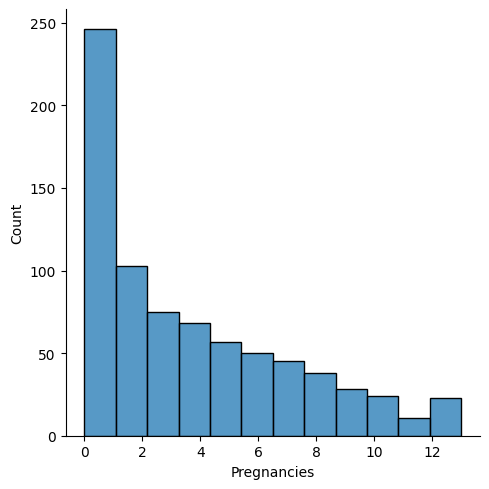

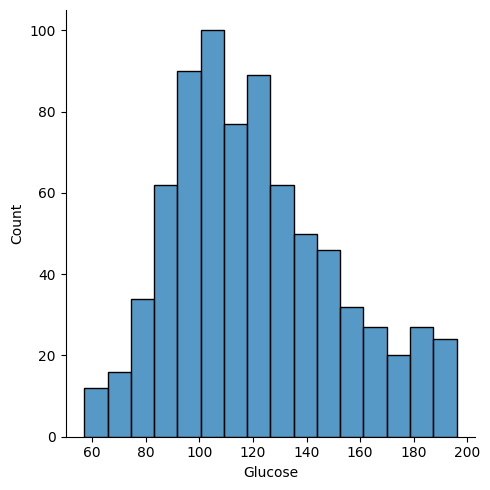

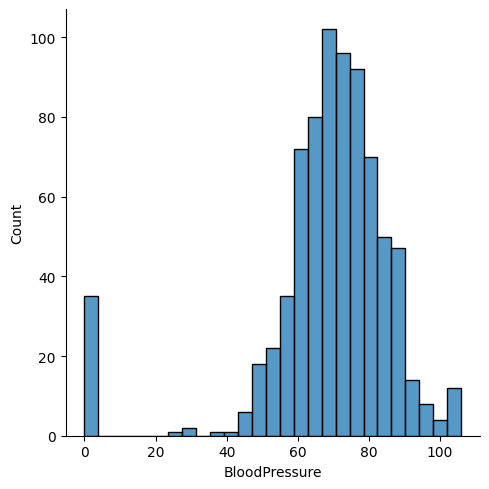

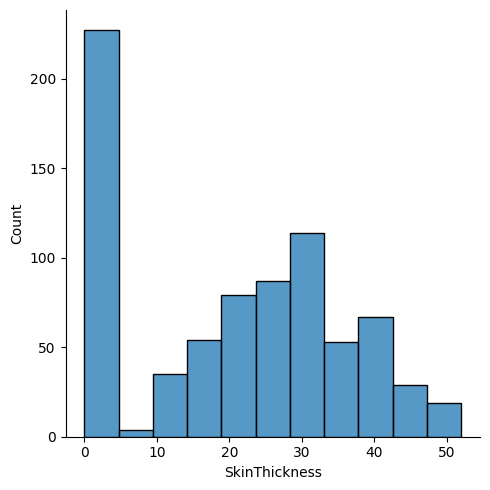

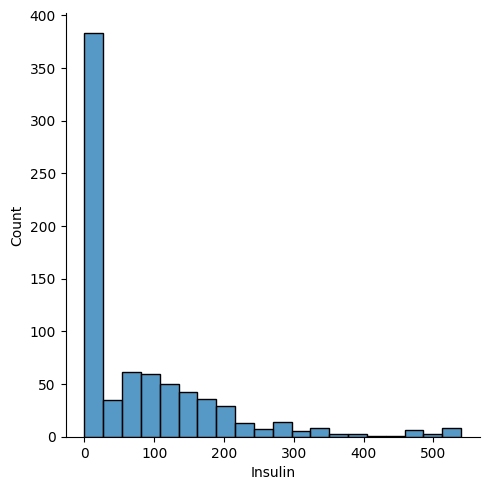

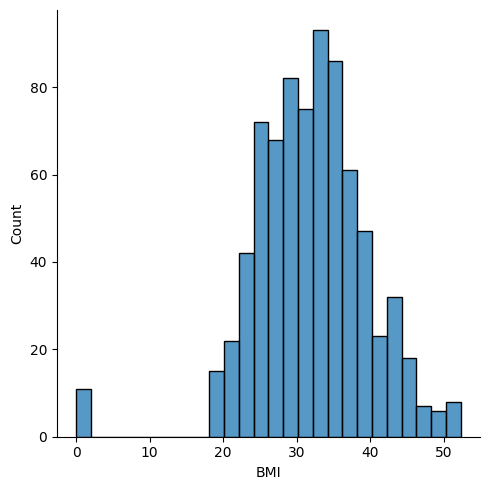

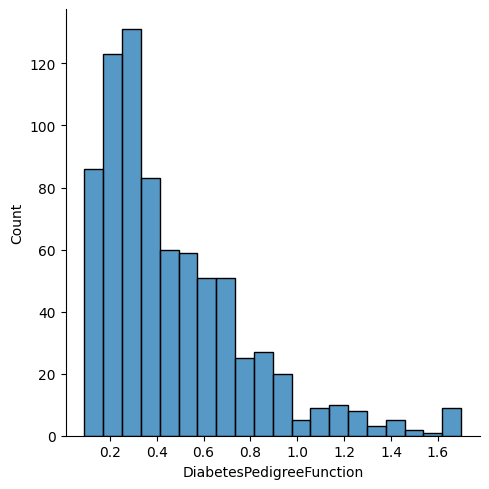

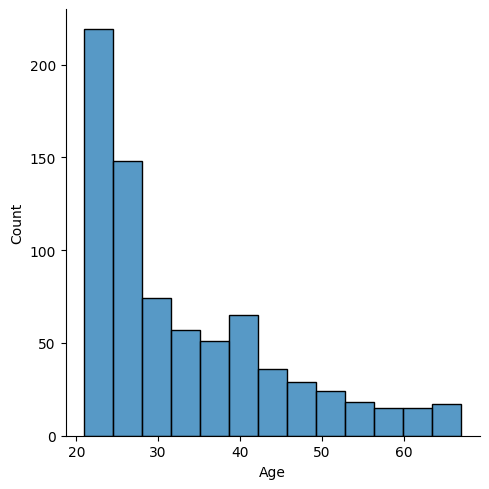

In [14]:
for predictor in predictors:
    sns.displot(df[predictor])

### **`Scaling & Normalisation`**

In [15]:
scaler = StandardScaler()

# scaling/normalizing numeric columns
numeric_cols = ['Glucose', 'BMI', 'Age', 'Pregnancies', 'DiabetesPedigreeFunction', 'Insulin', 'SkinThickness', 'BloodPressure']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.649356,0.868141,0.153224,0.930348,-0.715091,0.212677,0.503837,1.443088,1
1,-0.850059,-1.178147,-0.158776,0.546960,-0.715091,-0.690731,-0.373175,-0.189533,0
2,1.249122,2.004968,-0.262776,-1.306081,-0.715091,-1.116623,0.646828,-0.103605,1
3,-0.850059,-1.048224,-0.158776,0.163572,0.137787,-0.497143,-0.957850,-1.048806,0
4,-1.149942,0.510853,-1.510773,0.930348,0.809202,1.438731,3.910204,-0.017678,1
...,...,...,...,...,...,...,...,...,...
763,1.848887,-0.658454,0.361223,1.761021,0.918080,0.122336,-0.945140,2.560144,0
764,-0.550176,0.023642,0.049224,0.419164,-0.715091,0.625664,-0.408129,-0.533242,0
765,0.349473,-0.008839,0.153224,0.163572,0.301104,-0.742354,-0.709999,-0.275460,0
766,-0.850059,0.153565,-0.470775,-1.306081,-0.715091,-0.239027,-0.379531,1.185306,1


### **`Feature Engineering`**

While an important factor to consider, we feel that the current set of predictors/features are sufficient.

We considered creating dummies/buckets for the age variable however, that would take away from the accuracy.

### **`Handling Imbalanced Data`**

Before we do any handling, lets look at the distribution of those with diabetes vs no diabetes, the 'Outcome' variable.

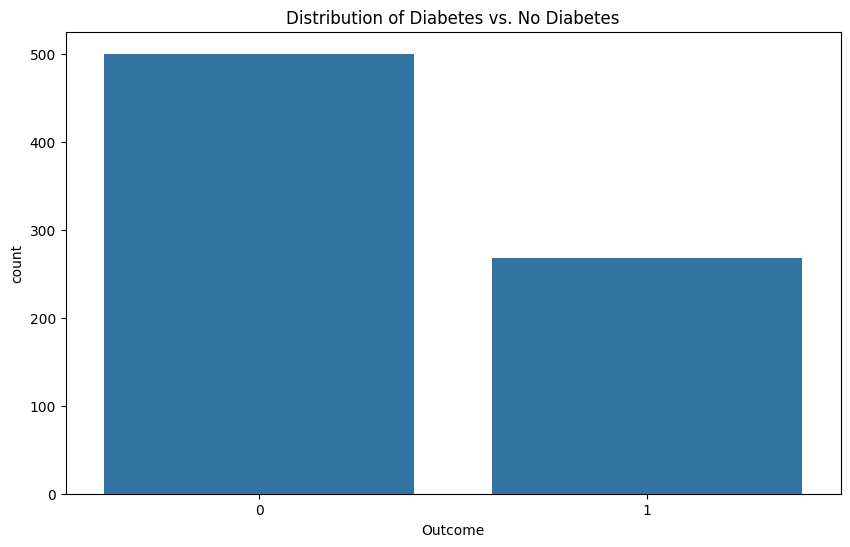

In [16]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Outcome')
plt.title('Distribution of Diabetes vs. No Diabetes')

plt.show()

So, we can see that there clearly is an imbalances in the Outcome variable, there are almost double the amount of 'No Diabetes (0)' instances as opposed to those with diabetes (1).

If we were to move forward with this, the model would place a bias for those with 'No Diabetes' and as a result negatively affecting any future predictions.

As such, we'll have to handle this by either:

* Oversampling the 'Dibetes' instances
* Undersampling the 'No Diabetes' instances.

Let's take care of that - we're going to apply the 'SMOTE - Synthetic Minority `Oversampling` Technique.

In [156]:
# Setting up X and y variables
X = df.drop(columns=['Outcome'])
y = df['Outcome']

# train/test split - we will shuffle our data, removing any sampling bias in how the data was recorded.
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=.2, random_state=0)

# Applying smote - we only apply it to the training portion as we dont want to introduce data leakage.
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Part III : Training ML Model

For this task, you are required to build a machine learning model to predict the outcome variable. This will be a binary classification task, as the target variable is binary. You should select at least two models, one of which should be an ensemble model, and compare their performance.

- Train the models: Train the selected models on the training set.
- Model evaluation: Evaluate the trained models on the testing set using appropriate evaluation metrics, such as accuracy, precision, recall, F1-score, and ROC-AUC.
- Model comparison: Compare the performance of the selected models and choose the best-performing model based on the evaluation metrics. You can also perform additional analysis, such as model tuning and cross-validation, to improve the model's performance.

### **`Logistic Regression`**

We'll first apply a logistic regression (Classification model) as our baseline model

Lets fit the model:

In [157]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(random_state=0)

logreg_model.fit(X_train_smote, y_train_smote)

LogisticRegression(random_state=0)

Let's now make some predictions:

In [158]:
y_pred = logreg_model.predict(X_test)

Let's apply some evaluation metrics:

In [159]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

logreg_acc = accuracy_score(y_test, y_pred)
logreg_precis = precision_score(y_test, y_pred)
logreg_recall = recall_score(y_test, y_pred)
logreg_f1 = f1_score(y_test, y_pred)
logreg_rocauc = roc_auc_score(y_test, y_pred)
logreg_confmatr = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {logreg_acc:.3f}")
print(f"Precision: {logreg_precis:.3f}")
print(f"Recall: {logreg_recall:.3f}")
print(f"F1 Score: {logreg_f1:.3f}")
print(f"ROC-AUC: {logreg_rocauc:.3f}")
print(f'\nThe confusion matrix is: \n\n{logreg_confmatr}')


Accuracy: 0.760
Precision: 0.578
Recall: 0.787
F1 Score: 0.667
ROC-AUC: 0.767

The confusion matrix is: 

[[80 27]
 [10 37]]


Let's apply a 5-fold cross-validation, spliting our data 80/20 but 5 different ways.

In [160]:
from sklearn.model_selection import cross_val_score

logreg_crossvalid = cross_val_score(logreg_model, X_train_smote, y_train_smote, cv=5, scoring='roc_auc')

print(f'The mean ROC-AUC score across our 5 fold split is: {logreg_crossvalid.mean():.3f}')

The mean ROC-AUC score across our 5 fold split is: 0.823


### **`Random Forest - Ensemble Method`**

Our second model for comparison will be a random forest approach - we'll compare the results to the logistic regression and see which performs better and by how much.

In [161]:
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=0)

Fitting the model:

In [162]:
rfc_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=0)

Let's make apply a prediction:

In [163]:
rfc_y_pred = rfc_model.predict(X_test)

And now, apply some evaluation metrics:

In [164]:
rfc_acc = accuracy_score(y_test, rfc_y_pred)
rfc_precis = precision_score(y_test, rfc_y_pred)
rfc_recall = recall_score(y_test, rfc_y_pred)
rfc_f1 = f1_score(y_test, rfc_y_pred)
rfc_rocauc = roc_auc_score(y_test, rfc_y_pred)
rfc_confmatr = confusion_matrix(y_test, rfc_y_pred)

print(f'Accuracy: {rfc_acc:.3f}')
print(f'Precision: {rfc_precis:.3f}')
print(f'Recall: {rfc_recall:.3f}')
print(f'F1 Score: {rfc_f1:.3f}')
print(f'ROC-AUC Score: {rfc_rocauc:.3f}')
print(f'\nThe Confusion Matrix: \n\n{rfc_confmatr}')

Accuracy: 0.805
Precision: 0.660
Recall: 0.745
F1 Score: 0.700
ROC-AUC Score: 0.788

The Confusion Matrix: 

[[89 18]
 [12 35]]


Like in the Logistic Regression, let's apply a 5-fold cross validation:

In [165]:
rfc_crossvalid = cross_val_score(rfc_model, X_train_smote, y_train_smote, cv=5, scoring='roc_auc')

print(f'The mean ROC-AUC score across our 5 fold split is: {rfc_crossvalid.mean():.3f}')

The mean ROC-AUC score across our 5 fold split is: 0.885


Since we evaluated the same metrics for both models, lets take a look at the results side-by-side:

In [166]:
print('            Log Reg | RF (Ensemble) | Delta')
print('---------------------------------------------')
print(f'Accuracy  |  {logreg_acc:.3f}  |    {rfc_acc:.3f}      | {rfc_acc - logreg_acc:.3f}')
print(f'Precision |  {logreg_precis:.3f}  |    {rfc_precis:.3f}      | {rfc_precis - logreg_precis:.3f}')
print(f'Recall    |  {logreg_recall:.3f}  |    {rfc_recall:.3f}      | {rfc_recall - logreg_recall:.3f}')
print(f'F1 Score  |  {logreg_f1:.3f}  |    {rfc_f1:.3f}      | {rfc_f1 - logreg_f1:.3f}')
print(f'ROC-AUC   |  {logreg_rocauc:.3f}  |    {rfc_rocauc:.3f}      | {rfc_rocauc - logreg_rocauc:.3f}')
print(f'5 CV      |  {logreg_crossvalid.mean():.3f}  |    {rfc_crossvalid.mean():.3f}      | {rfc_crossvalid.mean() - logreg_crossvalid.mean():.3f}')
print('---------------------------------------------')
print(f'Log Reg Confusion Matrix: \n\n{logreg_confmatr}')
print(f'\nRandom Forest Confusion Matrix: \n\n{rfc_confmatr}')

            Log Reg | RF (Ensemble) | Delta
---------------------------------------------
Accuracy  |  0.760  |    0.805      | 0.045
Precision |  0.578  |    0.660      | 0.082
Recall    |  0.787  |    0.745      | -0.043
F1 Score  |  0.667  |    0.700      | 0.033
ROC-AUC   |  0.767  |    0.788      | 0.021
5 CV      |  0.823  |    0.885      | 0.062
---------------------------------------------
Log Reg Confusion Matrix: 

[[80 27]
 [10 37]]

Random Forest Confusion Matrix: 

[[89 18]
 [12 35]]


It appears that the Random Forest (Ensemble) approach outperformed the base model Logistic Regression in every single metrix other than 'Recall'. This would suggest that the Logisitic Regerssion is slightly better at identifying actual positive cases of diabetes as opposed to the Random Forest model.

That being said, the Random Forest was more accuracte at predicting outcomes, is more likely to be correct, better ability in distinguishing between both classes and also performs better across different subsets of the dataset (tested with 5 different subsets)

Given that we're dealing with healthcare data, correctly indentifying patients with diabetes diagnoses may be more important and therefore, recall may be more valued as a metric.

# Part IV : Conclusion

From the machine learning models developed and the exploratory data analysis (EDA) conducted, generate four bullet points as your findings.

### **`4 Interesting Fidings`**

* Glucose levels inevitably presented with the most significant relationship with the outcome variable - we know that high levels of glucose (hyperglycemia) is as a result of low insulin levels and thus Type 1 Diabetes while the opposite it true for Type 2 Diabetes

* The given dataset shows that the average age for those with diabetes is ~37 while the average age for those without diabetes is ~31 - while this dataset is only a tiny sample of the population, it would be interesting to see what physiological process change/occur between 31 and 37 that that leads to diabetes, surely it cannot be purely dietry or heriditary.
Looking back to the correlation analysis of all predictors vs outcome, the DiabetesPedigreeFunction (figure that evaluates family history) presented with only a 0.173844 correlation - while correlation does not equal causation, it does inform on the general relationship.

* The Logistic Regression base model peformed better at Recall, where it was better able to correctly identify positive cases - this may be of greater use when trying to diagnose patients correctly.

* The Random Forest Approach (Ensemble) method outperformed the base model in every other metric (other than recall) and evidently portrays a better balance between recall and precision.
